# Run JWST pipeline to reprocess NIRSpec MOS data

DRAFT demo notebook running the JWST pipeline on NIRSpec MOS data from ERO program 2736: SMACS0723 (JWST's "First Deep Field")

We make two key adjustments to input parameters:
* outlier rejection of cosmic rays and snowballs: detector1 jump step 
* extraction rows for 1D spectrum (x1d) from 2D spectrum (s2d): extract1d [ystart – ystop]

JWST Pipeline
* https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview
* https://jwst-pipeline.readthedocs.io
* https://github.com/spacetelescope/jwst

NIRSpec MOS pipeline caveats and workaround notebooks:
* https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats
* https://github.com/spacetelescope/jwst-caveat-examples/tree/main/NIRSPEC_General
* https://github.com/spacetelescope/jwst-caveat-examples/tree/main/NIRSPEC_MOS

Notebooks running pipeline on simulated data:
* https://github.com/spacetelescope/jwebbinar_prep/blob/webbinar7/mos_session/jwebbinar7_nirspecmos.ipynb 28 Oct 2021 James Muzerolle
* https://github.com/spacetelescope/dat_pyinthesky/blob/main/jdat_notebooks/mos-spectroscopy/MOSspec_sv06_revised.ipynb 2021
* https://github.com/eclake/NIRSpec_GTO_sims_STScI_reduction/blob/master/NIRSpec%20GTO%20IPS%20Simultions.ipynb 21 Jun 2022 Emma Curtis-Lake (JADES)

msaexp notebook running pipeline on ERO SMACS0723:
* https://github.com/gbrammer/msaexp/blob/main/docs/examples/process-smacs0723.ipynb

See also: 
* MOSViz: https://spacetelescope.github.io/jdat_notebooks/notebooks/mos_spectroscopy_advanced/MOSspec_advanced.html
* JDAT: https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis/data-analysis-example-jupyter-notebooks
* msaexp: https://github.com/gbrammer/msaexp

# JWST Science Calibration Pipeline
https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview  
https://jwst-pipeline.readthedocs.io  
`pip install jwst`

### Pipeline Stages
uncal (counts) –> rate (slopes) –> cal (calibrated) –> s2d (2D spectra) –> x1d (1D spectra)

In [1]:
import os
home = os.path.expanduser("~")
from glob import glob
import numpy as np
from astropy.io import fits

In [2]:
# Define CRDS paths *before* importing jwst pipeline
# otherwise you'll get FileNotFoundError: [Errno 2] : No such file or directory: '$HOME/crds_cache/config/jwst/server_config'

#os.environ["CRDS_PATH"] = "$HOME/crds_cache"
#os.environ["CRDS_PATH"] = '/grp/crds/cache/' at STScI
os.environ["CRDS_PATH"] = os.path.join(home, "crds_cache")
os.makedirs(os.environ['CRDS_PATH'], exist_ok=True)

os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
print(os.environ['CRDS_PATH'])

/Users/dcoe/crds_cache


In [3]:
import jwst
import crds
from jwst import datamodels
from jwst.pipeline import Detector1Pipeline   #calwebb_detector1
from jwst.pipeline import Spec2Pipeline       #calwebb_spec2
from jwst.pipeline import Spec3Pipeline       #calwebb_spec3
from jwst.extract_1d import Extract1dStep     #Extract1D Individual Step
import json

# JWST version won't be right if development version (may say 1.12.3 when it's really 1.12.6)
print("JWST Calibration Pipeline Version={}".format(jwst.__version__)) 
print("Current Operational CRDS Context = {}".format(crds.get_default_context()))

JWST Calibration Pipeline Version=1.12.5
Current Operational CRDS Context = jwst_1179.pmap


In [74]:
import matplotlib # as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})  # 18

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe # https://stackoverflow.com/questions/25426599/matplotlib-how-to-buffer-label-text

from astropy.visualization import simple_norm, ImageNormalize, AsinhStretch, ManualInterval, LogStretch, LinearStretch
from astropy.stats import sigma_clip, sigma_clipped_stats  # , SigmaClip

In [86]:
cmap = 'viridis'
#bad_color = 1, 0.7, 0.7
bad_color = 'r'
cmap = matplotlib.colormaps[cmap]
cmap.set_bad(bad_color, 1.)

# Start with UNCAL files

https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html  

https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html  

https://outerspace.stsci.edu/display/MASTDOCS/API+Advanced+Search

In [16]:
import astroquery
print('astroquery version', astroquery.__version__)
from astroquery.mast import Observations, Mast

from astropy.table import Table, vstack, unique

astroquery version 0.4.6


In [139]:
#Observations.get_metadata("products")  # list all possible keyword filters

In [42]:
def download_jwst_files(filenames, download_dir, mast_dir='mast:jwst/product'):
    # Download data
    # https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data
    #manifest = Observations.download_products(chosen_obsIDs, download_dir=DOWNLOAD_DIR)  # , flat=True

    downloaded_files = []
    os.makedirs(download_dir, exist_ok=True)
    for filename in filenames:
        filename   = os.path.basename(filename)
        mast_path  = os.path.join(mast_dir,     filename)
        local_path = os.path.join(download_dir, filename)
        Observations.download_file(mast_path,   local_path=local_path)
        downloaded_files.append(local_path)

    return downloaded_files

In [26]:
obs_table = Observations.query_criteria(obs_collection = 'JWST', 
                                        proposal_id = 2736,  # program number 2736: ERO SMACS0723
                                        instrument_name = 'NIRSPEC/MSA',
                                        filters = 'g395m',
                                        dataproduct_type = 'spectrum',
                                       )

products_list = Observations.get_product_list(obs_table)  # all output products including images, catalogs, etc.

2023-12-31 07:16:09,134 - stpipe - WARNING - InputWarning: Filter observation_class does not exist. This filter will be skipped.


In [21]:
data_products = Observations.filter_products(products_list, 
                                            productType = 'SCIENCE', 
                                            productSubGroupDescription = 'UNCAL',  # UNCAL, RATE[INTS], CAL[INTS], I2D, S2D, X1D, ASN
                                            )  

In [320]:
#data_products

In [140]:
# Only keep science files with full data; not smaller files (target acq?)
file_sizes = unique(data_products, keys='size')['size']
print(file_sizes)
big_files = data_products[data_products['size'] > np.mean(file_sizes)]
#uncal_files = unique(data_products, keys='productFilename')['productFilename']
uncal_files = unique(big_files, keys='productFilename')['productFilename']
uncal_files

   size  
---------
 25220160
 25248960
 25251840
262198080
524341440


<MaskedColumn name='productFilename' dtype='str52' length=16>
jw02736007001_03101_00001_nrs1_uncal.fits
jw02736007001_03101_00001_nrs2_uncal.fits
jw02736007001_03103_00001_nrs1_uncal.fits
jw02736007001_03103_00001_nrs2_uncal.fits
jw02736007001_03103_00002_nrs1_uncal.fits
jw02736007001_03103_00002_nrs2_uncal.fits
jw02736007001_03103_00003_nrs1_uncal.fits
jw02736007001_03103_00003_nrs2_uncal.fits
jw02736008001_03101_00001_nrs1_uncal.fits
jw02736008001_03101_00001_nrs2_uncal.fits
jw02736008001_03103_00001_nrs1_uncal.fits
jw02736008001_03103_00001_nrs2_uncal.fits
jw02736008001_03103_00002_nrs1_uncal.fits
jw02736008001_03103_00002_nrs2_uncal.fits
jw02736008001_03103_00003_nrs1_uncal.fits
jw02736008001_03103_00003_nrs2_uncal.fits

In [112]:
uncal_file = uncal_files[2]
uncal_file

'jw02736007001_03103_00001_nrs1_uncal.fits'

In [44]:
download_dir = 'data'

In [46]:
#download_jwst_files(uncal_files, download_dir)
download_jwst_files([uncal_file], download_dir)

['data/jw02736007001_03101_00001_nrs1_uncal.fits']

# Stage 1: Detector1Pipeline: uncal –> rate

In [4]:
det1 = Detector1Pipeline()

2023-12-31 07:00:39,929 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2023-12-31 07:00:39,933 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2023-12-31 07:00:39,936 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2023-12-31 07:00:39,937 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2023-12-31 07:00:39,940 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2023-12-31 07:00:39,941 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2023-12-31 07:00:39,942 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2023-12-31 07:00:39,944 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2023-12-31 07:00:39,946 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2023-12-31 07:00:39,947 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2023-12-31 0

In [9]:
#det1.__dict__  # view entire contents
#det1.jump.__dict__  # view entire contents of jump step parameters

for key in 'expand_large_events min_sat_area min_jump_area'.split():
    print(key.ljust(20), det1.jump.__dict__[key])

expand_large_events  False
min_sat_area         1.0
min_jump_area        5.0


In [ ]:
output_dir = 'reprocess'
os.makedirs(output_dir, exist_ok=True)

CEERS NIRSpec reduction parameters to improve jump step rejection of cosmic rays and snowballs  
https://web.corral.tacc.utexas.edu/ceersdata/DR07/NIRSpec/README_NIRSpec_DR0.7.txt

In [15]:
# CEERS NIRSpec reduction parameters to improve jump step rejection of cosmic rays and snowballs
# https://web.corral.tacc.utexas.edu/ceersdata/DR07/NIRSpec/README_NIRSpec_DR0.7.txt

det1.jump.expand_large_events = True
det1.jump.min_sat_area  = 15.0
det1.jump.min_jump_area = 15.0

det1.save_results = True
det1.output_dir = output_dir

det1_result = det1.run(uncal_file)  # https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/call_via_run.html

In [117]:
det1_result = det1.run(uncal_file)  # took 14 minutes on a MacBook Pro laptop (with reference files already downloaded)

2023-12-31 16:04:52,024 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('data/jw02736007001_03103_00001_nrs1_uncal.fits',).
2023-12-31 16:04:52,033 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'reprocess', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'detector1pipeline', 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, '

<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs1_rate.fits>

In [144]:
#det1_result.__dict__  # view entire contents
det1_result.meta.filename

'jw02736007001_03101_00001_nrs1_rate.fits'

In [145]:
det1_result.data.shape

(2048, 2048)

In [ ]:
# Process them all

for uncal_file in sorted(uncal_files): 

    print(os.path.basename(uncal_file))

    det1 = Detector1Pipeline()

    det1.jump.expand_large_events = True
    det1.jump.min_sat_area  = 15.0
    det1.jump.min_jump_area = 15.0

    det1.save_results = True
    det1.output_dir = output_dir
    det1_result = det1.run(uncal_file)  

## Show rate file

In [126]:
def show_MOS_rate(rate_file, save_plot=False, close_plot=False, integration=None, cmap=cmap):
    # slits_model can be either s2d or cal from spec2 -- contains slit models for all the sources
    
    with fits.open(rate_file) as hdu_list:
        data = hdu_list['SCI'].data
        if integration == 'min':
            data = data.min(axis=0)
        elif integration != None:
            data = data[integration]
        
    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    
    #norm = simple_norm(data, 'asinh', min_percent=20, max_percent=98)
    norm = ImageNormalize(vmin=-0.003, vmax=0.022, stretch=AsinhStretch())
    #print(norm.vmin, norm.vmax)
    # Turn off interpolation! Or else bad pixels will appear to grow in the plot
    im  = ax.imshow(data, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')    
    
    title = os.path.basename(rate_file)
    if integration != None:
        title = title.replace('rateints', 'rateints[%s]' % integration)

    plt.title(title)
    print(title)

    if save_plot:
        if type(save_plot) != type('a.fits'):
            save_plot = rate_file.replace('fits', 'png')
            if integration != None:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
        plt.savefig(save_plot, dpi=200)

    if close_plot:
        plt.close()

## The adjusted jump step parameters effectively reject cosmic rays and snowballs

jw02736007001_03103_00001_nrs1_rate.fits


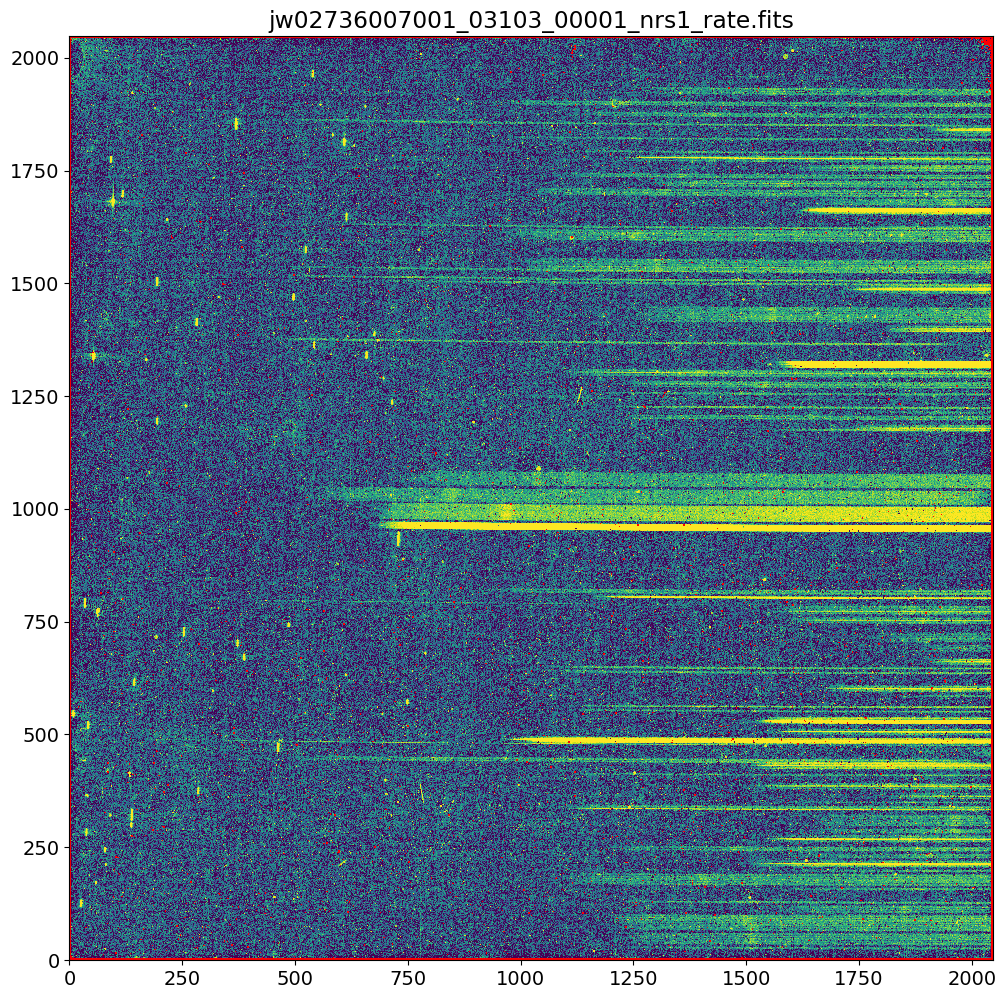

In [128]:
rate_file = os.path.basename(uncal_file).replace('_uncal.fits', '_rate.fits')
rate_file = os.path.join(output_dir, rate_file)
show_MOS_rate(rate_file)

## The default jump step parameters don't work as well

Compare to the data product in MAST generated using the pipeline with default parameters

2023-12-31 16:28:45,827 - stpipe - INFO - Found cached file data/jw02736007001_03103_00001_nrs1_rate.fits with expected size 83943360.


INFO: Found cached file data/jw02736007001_03103_00001_nrs1_rate.fits with expected size 83943360. [astroquery.query]
jw02736007001_03103_00001_nrs1_rate.fits


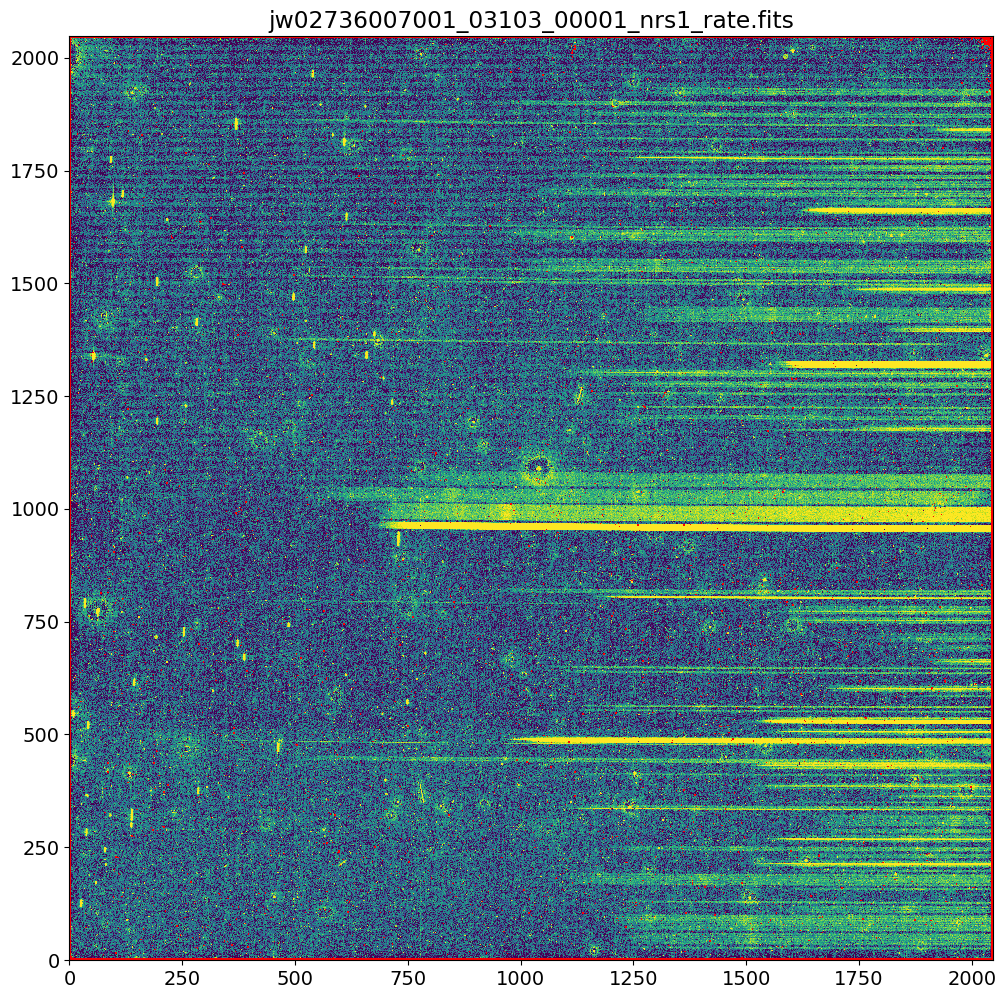

In [136]:
MAST_rate_file = download_jwst_files([rate_file], download_dir)[0]
show_MOS_rate(MAST_rate_file)

In [ ]:
display_images(data1, data2, -0.01, 0.02, rate_file1, rate_file2)

In [ ]:
image = data#[0, :, :]
#show_image(image, -1.e0, 2.e0, scale='linear')
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.imshow(image, origin='lower', vmin=-0.01, vmax=0.02)

Master Background performed in spec2

https://jwst-pipeline.readthedocs.io/en/latest/jwst/master_background/description.html

In [ ]:
rate_file = '../reprocess/jw04212002001_05101_00001_nrs1_s02661_rate.fits'

In [ ]:
hdu_list = fits.open(rate_file)
msa_metafile = hdu_list[0].header['MSAMETFL']
msa_metafile = os.path.join(output_dir, msa_metafile)
hdu_list = fits.open(msa_metafile)
hdu_list.info()

In [ ]:
spec2pipe = Spec2Pipeline()

In [ ]:
output_dir

In [ ]:
#spec2pipe.nsclean.skip = False  # Run NSClean 1/f noise striping removal
#spec2pipe.resample_spec.weight_type = 'exptime' # better for high SNR data – see NS-MOS07 https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats
spec2pipe.pathloss.skip = True  # Skip path loss corrections
spec2pipe.save_results = True
spec2pipe.output_dir = output_dir
#spec2pipe.master_background.save_background = True  # output the master background spectrum

In [ ]:
# Run Spec2Pipeline
result = spec2pipe(rate_file)

# Stage 2: Spec2Pipeline: rate –> cal, s2d, x1d

Run on an individual file (could also run on an association of multiple files)

Spec2Pipeline takes 5 minutes on a MacBook Pro laptop (with reference files already downloaded)

In [ ]:
output_dir = 'reprocess'
#rate_files = glob(os.path.join(output_dir, '*_rate.fits'))
rate_files = [rate_file]

for rate_file in rate_files:
    try:
        # Download MSA metafile
        msa_file = fits.getval(rate_file, 'MSAMETFL')
        download_jwst_files([msa_file], output_dir)
    
        spec2pipe = Spec2Pipeline()
        #spec2pipe.resample_spec.weight_type = 'exptime' # better for high SNR data – see NS-MOS07 https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats
        #spec2pipe.pathloss.skip = True  # Skip path loss corrections
        #spec2pipe.nsclean.skip = False  # Run NSClean 1/f noise striping removal (implemented in pipeline version 1.12.6 but off by default)
        spec2pipe.save_results = True
        spec2pipe.output_dir = output_dir
        spec2_result = spec2pipe(rate_file)
    except:
        print('spec2pipe FAILED on', rate_file)

Alternatively, can run Spec2Pipeline on an association of multiple files  
For example, 3 exposures (3 slitlet nods)  

In [184]:
# rate files need to be in same directory as association file  
if 0:
    association_file = 'data/jw02736-o007_20231116t144653_spec2_00005_asn.json'
    spec2_result = spec2pipe(association_file)

# spec3

Query MAST and download the spec3 association file used by the default JWST pipeline

https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html

In [303]:
# Alternatively, you could extract that info from the data products
#spec3_cal_asn_file = cal_model[0].meta.asn.table_name
#spec2_cal_asn_file = cal_model.exposures[0].meta.asn.table_name

In [195]:
#Observations.get_metadata('observations')  # list all criteria that may be used in query_criteria below

In [185]:
obs_table = Observations.query_criteria(obs_collection = 'JWST', 
                                        proposal_id = 2736,  # program number 2736: ERO SMACS0723
                                        instrument_name = 'NIRSPEC/MSA',
                                        filters = 'g395m',
                                        dataproduct_type = 'spectrum',
                                       )

products_list = Observations.get_product_list(obs_table)  # all output products including images, catalogs, etc.

https://mast.stsci.edu/api/v0/_productsfields.html

In [190]:
asn_data_products = Observations.filter_products(products_list, 
                                            productType = 'INFO', 
                                            productSubGroupDescription = 'ASN',  # UNCAL, RATE, RATEINTS, CAL, I2D, X1D, S2D, ASN
                                            type = 'D', # 'S': all objects;  'D': individual object
                                            )  

In [301]:
#asn_data_products

In [193]:
asn_files = unique(asn_data_products, keys='productFilename')
asn_filenames = asn_files['productFilename']
asn_filenames

<MaskedColumn name='productFilename' dtype='str52' length=2>
jw02736-o007_20231116t144653_spec3_00001_asn.json
jw02736-o008_20231116t144653_spec3_00001_asn.json

In [197]:
spec3_asn_files = download_jwst_files(asn_filenames, download_dir)

2024-01-01 10:45:00,250 - stpipe - INFO - Found cached file data/jw02736-o007_20231116t144653_spec3_00001_asn.json with expected size 5501.
2024-01-01 10:45:00,393 - stpipe - INFO - Found cached file data/jw02736-o008_20231116t144653_spec3_00001_asn.json with expected size 5501.


INFO: Found cached file data/jw02736-o007_20231116t144653_spec3_00001_asn.json with expected size 5501. [astroquery.query]
INFO: Found cached file data/jw02736-o008_20231116t144653_spec3_00001_asn.json with expected size 5501. [astroquery.query]


In [ ]:
spec3_asn_file = spec3_asn_files[0]

In [198]:
with open(spec3_asn_file) as f_obj:
    asn_data = json.load(f_obj)
    spec2_cal_files = []
    for member in asn_data['products'][0]['members']:
        if member['exptype'] == 'science':
            spec2_cal_file = member['expname']
            spec2_cal_files.append(spec2_cal_file)
            print(spec2_cal_file)

jw02736007001_03103_00001_nrs1_cal.fits
jw02736007001_03103_00001_nrs2_cal.fits
jw02736007001_03103_00002_nrs1_cal.fits
jw02736007001_03103_00002_nrs2_cal.fits
jw02736007001_03103_00003_nrs1_cal.fits
jw02736007001_03103_00003_nrs2_cal.fits


In [302]:
#asn_data

In [158]:
with open(spec3_asn_file) as f_obj:
    asn_data = json.load(f_obj)
    spec2_cal_files = []
    for member in asn_data['products'][0]['members']:
        if member['exptype'] == 'science':
            spec2_cal_file = member['expname']
            spec2_cal_files.append(spec2_cal_file)
            print(spec2_cal_file)

jw02736007001_03103_00001_nrs1_cal.fits
jw02736007001_03103_00001_nrs2_cal.fits
jw02736007001_03103_00002_nrs1_cal.fits
jw02736007001_03103_00002_nrs2_cal.fits
jw02736007001_03103_00003_nrs1_cal.fits
jw02736007001_03103_00003_nrs2_cal.fits


In [ ]:
# run the calwebb_spec3 pipeline using the association file as input

# Create a subdirectory for the many output files (several for each extracted source)
spec3_output_dir = os.path.join(output_dir, 'spec3')
os.makedirs(spec3_output_dir, exist_ok=True)

spec3pipe = Spec3Pipeline()
spec3.save_results = True
spec3.output_dir = spec3_output_dir

In [ ]:
result = spec3pipe(spec3_asn_file)

# extract1d

https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d

https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_1d.Extract1dStep.html

https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html#extraction-for-2d-slit-data

`extract_width` takes priority over `ystart` and `ystop` for the extraction width,   
but `ystart` and `ystop` will still be used to define the centering of the extraction region in the cross-dispersion direction.

All of these values are zero-indexed integers. The start and stop limits are inclusive.

https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html#editing-json-reference-file-format-for-non-ifu-data

The default EXTRACT1D reference file is found in CRDS. The user can download this file, modify the contents, and use this modified file in extract_1d by specifying this modified reference file with the override option


### See also

* Adjusting the extraction region:
https://github.com/spacetelescope/jwst-caveat-examples/blob/main/NIRSPEC_General/nrs_recenter_extraction_workaround.ipynb
* MOSViz interactive extraction: 
https://spacetelescope.github.io/jdat_notebooks/notebooks/mos_spectroscopy_advanced/MOSspec_advanced.html
* Optimal extraction:
https://spacetelescope.github.io/jdat_notebooks/notebooks/optimal_extraction/Spectral_Extraction-static.html
* msaexp optimal extraction:
https://github.com/gbrammer/msaexp/blob/d7368560cf465a0828e942454cfcc0bbe6870278/msaexp/drizzle.py#L869C19-L869C19


In [300]:
s2d_file = 'jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits'
s2d_file = os.path.join(download_dir, s2d_file)
s2d_model = datamodels.open(s2d_file)
s2d_data = s2d_model.data + 0

In [205]:
from jwst.extract_1d import Extract1dStep

In [220]:
# Default extract1d parameters from jwst-crds.stsci.edu
# (there should be some way to find and download the latest reference file)
default_extract1d_json_file = 'jwst_nirspec_extract1d_0003.json'

In [221]:
with open(default_extract1d_json_file) as f_obj:
    extract1d_json_data = json.load(f_obj)

In [214]:
extract1d_json_data

{'reftype': 'EXTRACT1D',
 'instrument': 'NIRSPEC',
 'telescope': 'JWST',
 'exp_type': 'NRS_MSASPEC',
 'pedigree': 'GROUND',
 'descrip': 'NIRSpec MSA extraction parameters for testing',
 'author': 'P. Hodge',
 'history': 'First draft 2016-Nov-11',
 'useafter': '2014-01-01T00:00:00',
 'apertures': [{'id': 'ANY',
   'region_type': 'target',
   'independent_var': 'pixel',
   'bkg_order': 0,
   'extract_width': 8,
   'dispaxis': 1}]}

### Define the extraction region

In [270]:
ystart = 19  # you decide where to start the extraction region
extract_width = extract1d_json_data['apertures'][0]['extract_width']
ystop = ystart + extract_width - 1
extract1d_json_data['apertures'][0]['ystart'] = ystart
extract1d_json_data['apertures'][0]['ystop']  = ystop

In [299]:
extract1d_json_data['apertures'][0]

{'id': 'ANY',
 'region_type': 'target',
 'independent_var': 'pixel',
 'bkg_order': 0,
 'extract_width': 8,
 'dispaxis': 1,
 'ystart': 19,
 'ystop': 26}

In [272]:
json_object = json.dumps(extract1d_json_data, indent=4)
custom_extract1d_json_file = 'jwst_nirspec_extract1d_custom.json'
with open(custom_extract1d_json_file, "w") as outfile:
    outfile.write(json_object)

In [266]:
extract1d_result = Extract1dStep.call(s2d_file,
                            use_source_posn=False, 
                            apply_apcorr=False,
                            override_extract1d = custom_extract1d_json_file,
                            save_results=True, output_dir=output_dir)

2024-01-01 20:36:31,749 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-01-01 20:36:32,628 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('data/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits',).
2024-01-01 20:36:32,630 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'reprocess', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': False, 'center_xy': None, 'apply_apcorr': False, 'ifu_autocen': False, 'ifu_rfcorr': False, 'ifu_set_srctype': None, 'ifu_rscale': None, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_grid_out': None, 'so

### Show the result

Here we've rerun extract_1d on the MAST s2d output. A future notebook update will show results from the full pipeline reprocessing above.

2024-01-01 21:28:05,694 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


s2d range: -0.8692266345024109 0.8521444201469421


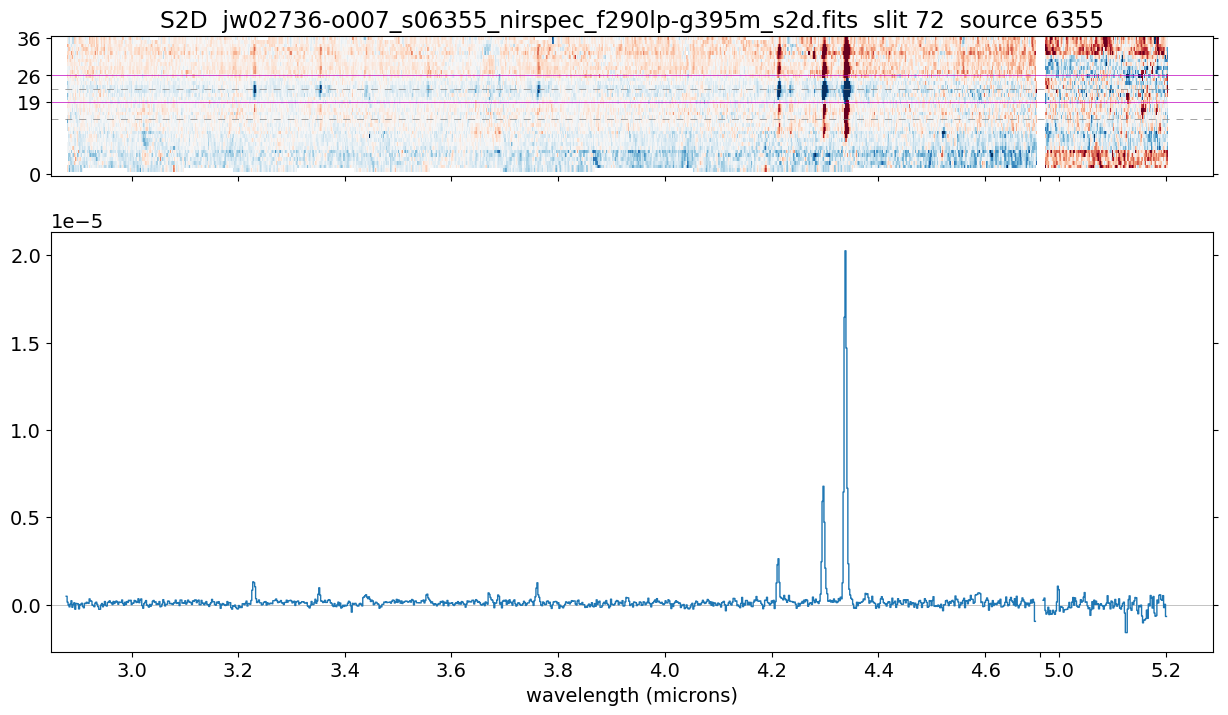

In [298]:
#def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='viridis', bad_color=(1,0.7,0.7), min_percent=2, max_percent=99.9, ymin=-2e-6, ymax=1e-5):
def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='RdBu', bad_color='w',
                     ystart=None, ystop=None): #, bad_color=(0.88,0.88,0.88)):
    # 2D spectrum
    #if source_id:  # s2d has all the objects; extract the one with source_id
    if 'slits' in list(s2d_model):  # s2d has all the objects; extract the one with source_id
        source_ids = [slit.source_id for slit in s2d_model.slits]
        i_slit = source_ids.index(source_id)
        slit_model = s2d_model.slits[i_slit]
    else:  # s2d only has one object
        slit_model = s2d_model
        i_slit = 0
        
    s2d_data = slit_model.data + 0  # load and make copy
    s2d_data = np.where(slit_model.err, s2d_data, np.nan)  # Replace zeros with nan where there is no data

    # 1D spectrum
    x1d_wave    = x1d_model.spec[i_slit].spec_table.WAVELENGTH
    x1d_flux    = x1d_model.spec[i_slit].spec_table.FLUX
    x1d_fluxerr = x1d_model.spec[i_slit].spec_table.FLUX_ERROR
    if np.sum(np.isnan(x1d_fluxerr)) == len(x1d_fluxerr):  # fluxerr all nan?? pipeline bug
        x1d_flux = np.where(x1d_flux, x1d_flux, np.nan)  # Replace zeros with nan where there is no data
    else:
        x1d_flux = np.where(np.isnan(x1d_fluxerr), np.nan, x1d_flux)  # Replace zeros with nan where there is no data
    #x1dflux = np.where(x1dfluxerr, x1dflux, np.nan)  # Replace zeros with nan where there is no data

    wave_min, wave_max = x1d_wave[0], x1d_wave[-1]
    eps = 1e-7
    #major_tick_interval = 0.5
    major_tick_interval = 0.2
    xtick_min = np.ceil((wave_min - eps) / major_tick_interval) * major_tick_interval
    xticks = np.arange(xtick_min, wave_max, major_tick_interval)
    #xticks = np.append(xticks, [5.2])
    num_waves = len(x1d_wave)
    xtick_pos = np.interp(xticks, x1d_wave, np.arange(num_waves))
    xtick_labels = ['%.1f' % xtick for xtick in xticks]
    
    #xtick_labels = [label.replace('4.8', '') for label in xtick_labels]  # remove 4.8
    # Remove any tick labels that are too close and would overlap
    for i in range(len(xtick_pos)-1):
        dx = xtick_pos[i+1] - xtick_pos[i]
        if dx < 40:
            xtick_labels[i] = ''
    
    #for label in xtick_labels: print(label, ' ', end='')

    # Make Figure
    fig, (ax2d, ax1d) = plt.subplots(2, 1, figsize=(15,8), height_ratios=[1,3], squeeze=True, sharex=True)
    cmap = matplotlib.colormaps[cmap]
    cmap.set_bad(bad_color, 1.)

    sigma_clipped_data = sigma_clip(s2d_data, sigma=5, maxiters=3)
    ymin = np.min(sigma_clipped_data)
    #ymin = 0.2 * ymin
    ymax = np.max(sigma_clipped_data)
    #ymin = -ymax  # center range about zero; but there may be some bias positive or negative

    #ymax = 2 * np.nanpercentile(s2d_data, 90)
    #ymin = -0.2 * ymax
    
    # plot the rectified 2D spectrum
    #norm = simple_norm(s2dsci, 'linear', min_percent=2, max_percent=99.9)
    #norm = simple_norm(s2d_data, 'asinh', min_percent=min_percent, max_percent=max_percent)
    norm = simple_norm(s2d_data, 'linear', min_cut=ymin, max_cut=ymax)
    print('s2d range:', norm.vmin, norm.vmax)
    im = ax2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')
    num_cross, num_dispersion = s2d_data.shape
    width_1d = 3
    ny, nx = s2d_data.shape
    ax2d.yaxis.set_ticks_position('both')
    #ax2d.axhline((ny-1)/2., c='w', lw=0.5, alpha=0.5, ls='--')
    if ystart:
        for y in ystart, ystop:
            #ax2d.axhline(y, c='w', lw=0.5, alpha=0.5, ls='--')
            ax2d.axhline(y, c='m', lw=0.5)
        ax2d.set_yticks([0, ystart, ystop, ny-1])
        if 1:
            extract_width = 8
            ystart0 = ny/2 - extract_width/2
            ystop0  = ny/2 + extract_width/2
            for y in ystart0, ystop0:
                ax2d.axhline(y, c='0.50', lw=0.5, ls='--', dashes=(10,10))
    else:
        ax2d.set_yticks([0, (ny-1)/2., ny-1])
    
    # plot the 1D extraction  x1d vs. indices, same as s2d array above
    ax1d.axhline(0, c='0.50', lw=0.5, alpha=0.66, ls='-')
    ax1d.step(np.arange(num_waves), x1d_fluxerr, lw=0.5, c='r', alpha=0.66)
    ax1d.step(np.arange(num_waves), x1d_flux, lw=1)
    ax1d.set_xlim(0, num_waves)
    ax1d.yaxis.set_ticks_position('both')

    #ax1d.set_ylim(-2e-6, 2e-5)
    #ax1d.set_ylim(ymin, ymax)
    
    title = 'S2D  ' + os.path.basename(s2d_model.meta.filename) 
    title += '  slit %d'   % slit_model.slitlet_id
    title += '  source %d' % slit_model.source_id
    ax2d.set_title(title)
    plt.xticks(xtick_pos, xtick_labels)
    plt.xlabel('wavelength (microns)');

#show_MOS_spectrum(s2d_model, x1d_model, source_id)
show_MOS_spectrum(s2d_model, extract1d_result, ystart=ystart, ystop=ystop)

In [306]:
s2d_file = 'jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits'
MAST_s2d_file = download_jwst_files([s2d_file], download_dir)[0]
MAST_s2d_model = datamodels.open(MAST_s2d_file)

2024-01-01 21:48:12,590 - stpipe - INFO - Found cached file data/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits with expected size 1566720.


INFO: Found cached file data/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits with expected size 1566720. [astroquery.query]


In [307]:
x1d_file = s2d_file.replace('s2d', 'x1d')
MAST_x1d_file = download_jwst_files([x1d_file], download_dir)[0]
MAST_x1d_model = datamodels.open(MAST_x1d_file)

2024-01-01 21:48:15,730 - stpipe - INFO - Found cached file data/jw02736-o007_s06355_nirspec_f290lp-g395m_x1d.fits with expected size 250560.


INFO: Found cached file data/jw02736-o007_s06355_nirspec_f290lp-g395m_x1d.fits with expected size 250560. [astroquery.query]


In [308]:
x1d_wave_MAST = MAST_x1d_model.spec[0].spec_table.WAVELENGTH
x1d_flux_MAST = MAST_x1d_model.spec[0].spec_table.FLUX

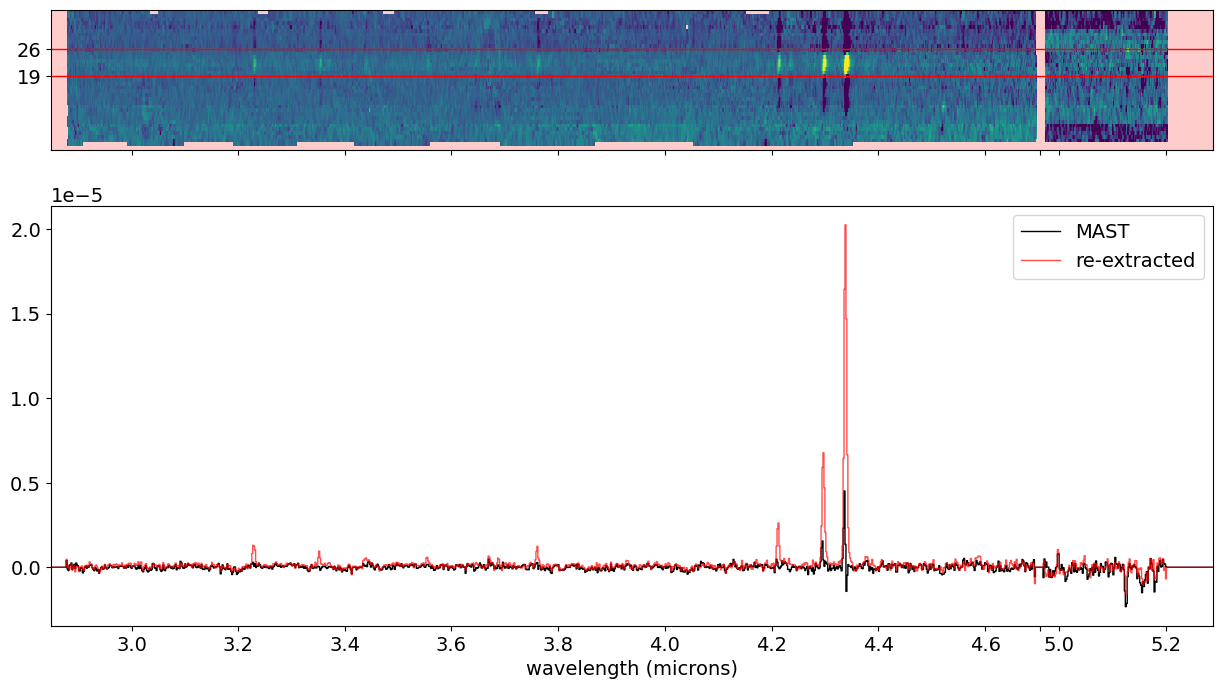

In [317]:
fig, (ax2d, ax1d) = plt.subplots(2, 1, figsize=(15,8), height_ratios=[1,3], squeeze=True, sharex=True)

# plot the rectified 2D spectrum
#norm = simple_norm(s2dsci, 'linear', min_percent=10, max_percent=99.9)
s2d_data = np.where(s2d_model.err, s2d_model.data, np.nan)  # Replace zeros with nan where there is no data
norm = simple_norm(s2d_data, 'asinh', min_percent=2, max_percent=99.95)
cmap = matplotlib.colormaps['viridis']
cmap.set_bad((1,0.8,0.8), 1.)
im = ax2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')

ax1d.step(np.arange(num_waves), x1d_flux_MAST, lw=1, c='k', label='MAST')
ax1d.step(np.arange(num_waves), x1d_flux,      lw=1, c='r', label='re-extracted', alpha=0.7)
#xlim = ax1d.get_xlim()
ax1d.set_xlim(0, num_waves)
ax2d.set_yticks([ystart, ystop])
for y in ystart, ystop:
    ax2d.axhline(y, c='r', alpha=1, lw=1, ls='-')

plt.xticks(xtick_pos, xtick_labels)
plt.xlabel('wavelength (microns)')
plt.legend();